<a href="https://colab.research.google.com/github/DayenaJeong/FS_neuron/blob/main/FS_conversion_poisson_softplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [4]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        if num_params == 4:
            h = torch.tensor([4.4682, 4.2097, 0.5166, 0.4746])
            d = torch.tensor([4.2236, 4.1465, 1.3406, 1.4113])
            T = torch.tensor([3.4595, 3.2402, 0.2901, 1.2908])
        elif num_params == 8:
            h = torch.tensor([1.4939, 1.6136, 4.7730, 2.4916, 1.4080, 0.9018, 1.0605, 0.3997])
            d = torch.tensor([0.4433, 1.3525, 4.7553, 2.4729, 1.3782, 0.8179, 0.5103, 0.2444])
            T = torch.tensor([-0.9802, 0.2283, 4.0217, 1.5428, 0.3840, -0.4479, -1.0518, -1.8225])
        elif num_params == 12:
            h = torch.tensor([1.1507, 1.9843, 4.1558, 2.2380, 1.1598, 1.1832, 0.6838, 0.9808, 0.9599, 1.5397, -2.4526, 1.5903])
            d = torch.tensor([0.7290, 1.9051, 4.1505, 2.2302, 1.1365, 0.9365, 0.4517, 0.2054, 0.1066, 0.0487, 0.1452, 0.1571])
            T = torch.tensor([0.5358, 2.1906, 4.5437, 2.4850, 1.3502, 0.6904, -0.0415, -1.2596, -2.2509, -3.8104, -3.8233, -1.2061])
        elif num_params == 16:
            h = torch.tensor([0.8390, 1.2366, 3.2619, 1.9236, 0.7046, 2.2526, 1.2453, 1.0133, 0.7192, 0.7911, 0.8382, 0.6877, 0.6364, 1.0113, 1.7649, 0.7065])
            d = torch.tensor([0.7098, 0.0542, 3.2631, 1.9232, 0.1635, 2.2172, 1.2149, 0.9410, 0.6259, 0.5588, 0.4810, 0.3097, 0.2454, 0.1651, 0.7377, 0.0692])
            T = torch.tensor([1.6926, -3.4559, 5.9155, 4.1239, -2.5486, 1.9903, 0.7669, 0.1584, -0.4227, -0.8991, -1.4492, -1.9575, -2.3678, -2.8489, 0.3304, -3.6109])


        self.h = nn.Parameter(h + torch.poisson(torch.full(h.size(), 0.1)).float())
        self.d = nn.Parameter(d + torch.poisson(torch.full(d.size(), 0.1)).float())
        self.T = nn.Parameter(T + torch.poisson(torch.full(T.size(), 0.1)).float())

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Softplus

K=4

Epoch 1/20000, Loss: 0.19750787317752838
Epoch 1001/20000, Loss: 0.12343320995569229
Epoch 2001/20000, Loss: 0.07517420500516891
Epoch 3001/20000, Loss: 0.075994573533535
Epoch 4001/20000, Loss: 0.07602543383836746
Epoch 5001/20000, Loss: 0.0760238841176033
Epoch 6001/20000, Loss: 0.07602450996637344
Epoch 7001/20000, Loss: 0.07602423429489136
Epoch 8001/20000, Loss: 0.07602354139089584
Epoch 9001/20000, Loss: 0.07602313160896301
Epoch 10001/20000, Loss: 0.07602638751268387
Epoch 11001/20000, Loss: 0.07602396607398987
Epoch 12001/20000, Loss: 0.07602529972791672
Epoch 13001/20000, Loss: 0.07601821422576904
Epoch 14001/20000, Loss: 0.07602103799581528
Epoch 15001/20000, Loss: 0.0760287269949913
Epoch 16001/20000, Loss: 0.07602699100971222
Epoch 17001/20000, Loss: 0.07602774351835251
Epoch 18001/20000, Loss: 0.07602403312921524
Epoch 19001/20000, Loss: 0.07602176070213318
Loss values: [0.19750787317752838, 0.14546002447605133, 0.14140138030052185, 0.13437816500663757, 0.13101203739643097

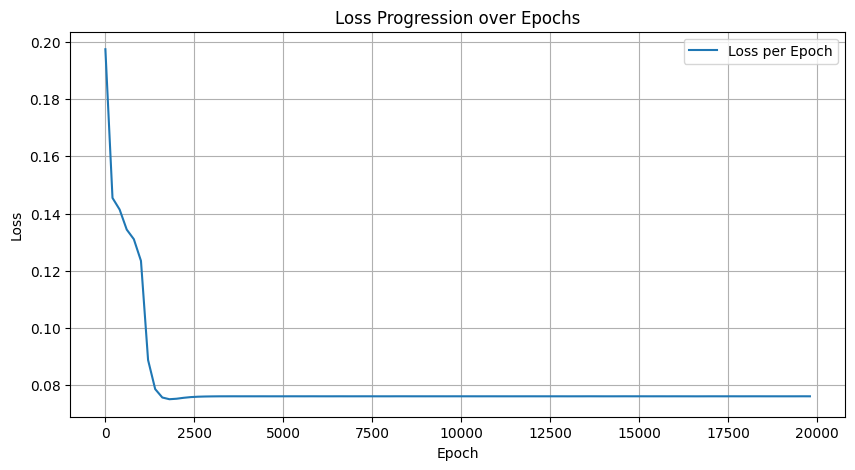

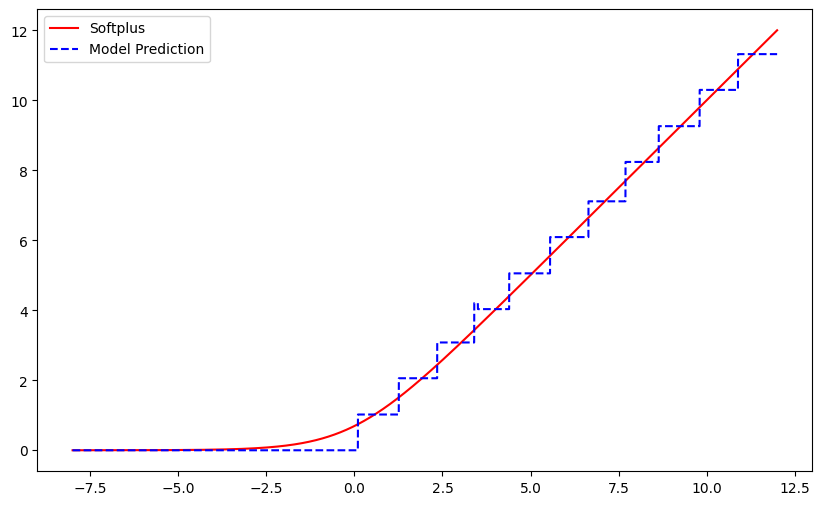

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=8

Epoch 1/20000, Loss: 0.5460306406021118
Epoch 1001/20000, Loss: 0.020125141367316246
Epoch 2001/20000, Loss: 0.011853893287479877
Epoch 3001/20000, Loss: 0.00597390066832304
Epoch 4001/20000, Loss: 0.005969581194221973
Epoch 5001/20000, Loss: 0.005906113423407078
Epoch 6001/20000, Loss: 0.0059164538979530334
Epoch 7001/20000, Loss: 0.006119398400187492
Epoch 8001/20000, Loss: 0.0062769073992967606
Epoch 9001/20000, Loss: 0.006531259976327419
Epoch 10001/20000, Loss: 0.006677021272480488
Epoch 11001/20000, Loss: 0.00674250116571784
Epoch 12001/20000, Loss: 0.005787264555692673
Epoch 13001/20000, Loss: 0.0058173490688204765
Epoch 14001/20000, Loss: 0.005817650351673365
Epoch 15001/20000, Loss: 0.005817921366542578
Epoch 16001/20000, Loss: 0.005817115306854248
Epoch 17001/20000, Loss: 0.005816757213324308
Epoch 18001/20000, Loss: 0.005816814489662647
Epoch 19001/20000, Loss: 0.005818505305796862
Loss values: [0.5460306406021118, 0.061327118426561356, 0.04177846759557724, 0.031729564070701

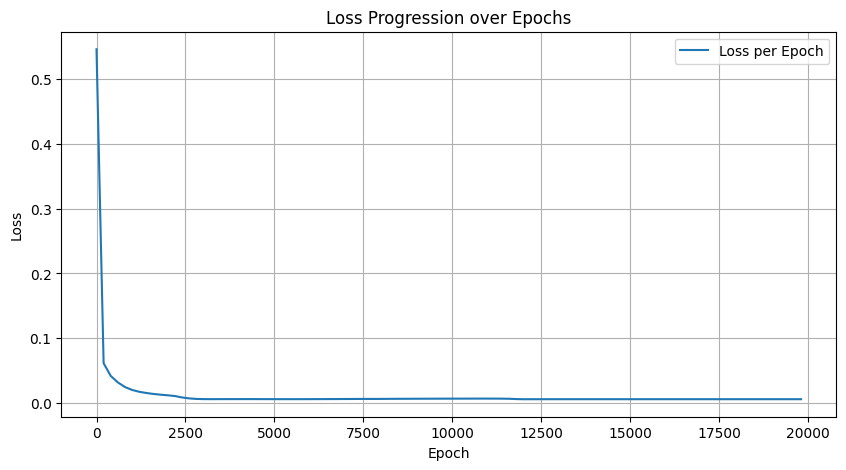

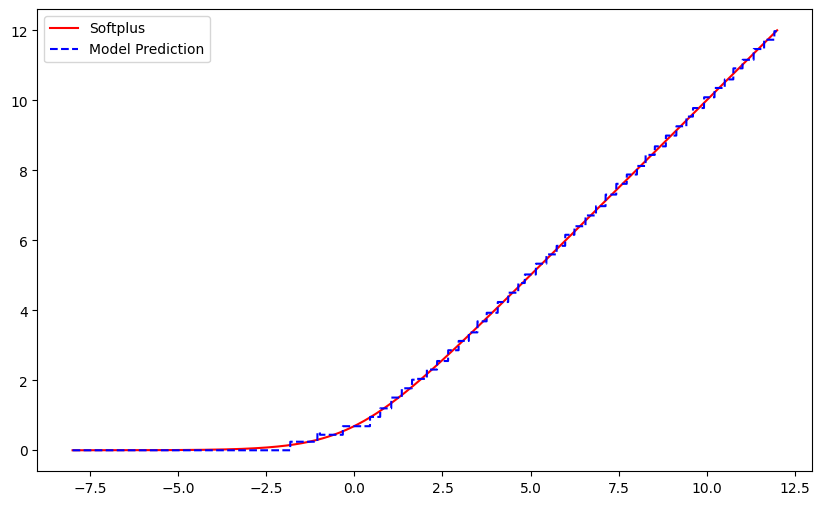

In [5]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=12

Epoch 1/20000, Loss: 0.39547252655029297
Epoch 1001/20000, Loss: 0.013711340725421906
Epoch 2001/20000, Loss: 0.00414061127230525
Epoch 3001/20000, Loss: 0.003528336528688669
Epoch 4001/20000, Loss: 0.0031248664017766714
Epoch 5001/20000, Loss: 0.0028036239091306925
Epoch 6001/20000, Loss: 0.0023850786965340376
Epoch 7001/20000, Loss: 0.001924379845149815
Epoch 8001/20000, Loss: 0.0021748607978224754
Epoch 9001/20000, Loss: 0.001604772754944861
Epoch 10001/20000, Loss: 0.0015665661776438355
Epoch 11001/20000, Loss: 0.0015389437321573496
Epoch 12001/20000, Loss: 0.0015239117201417685
Epoch 13001/20000, Loss: 0.0015524517511948943
Epoch 14001/20000, Loss: 0.0014886852586641908
Epoch 15001/20000, Loss: 0.0014623769093304873
Epoch 16001/20000, Loss: 0.0014678632142022252
Epoch 17001/20000, Loss: 0.0014514499343931675
Epoch 18001/20000, Loss: 0.001557831303216517
Epoch 19001/20000, Loss: 0.0015343745471909642
Loss values: [0.39547252655029297, 0.03879815340042114, 0.029314275830984116, 0.02

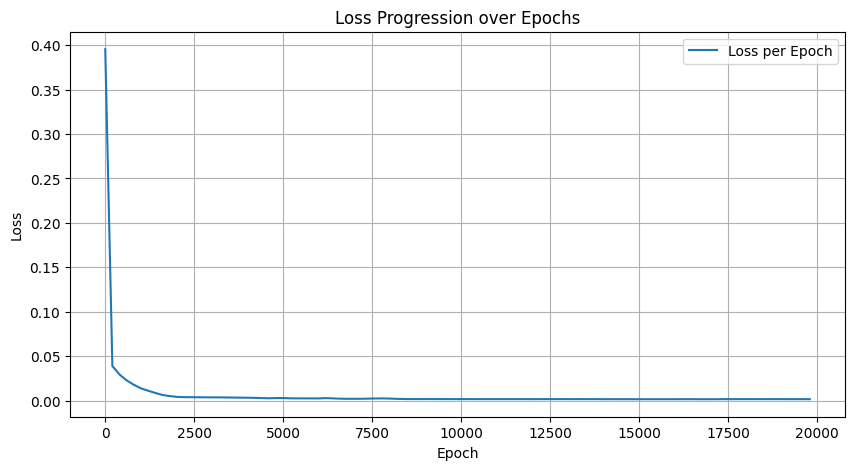

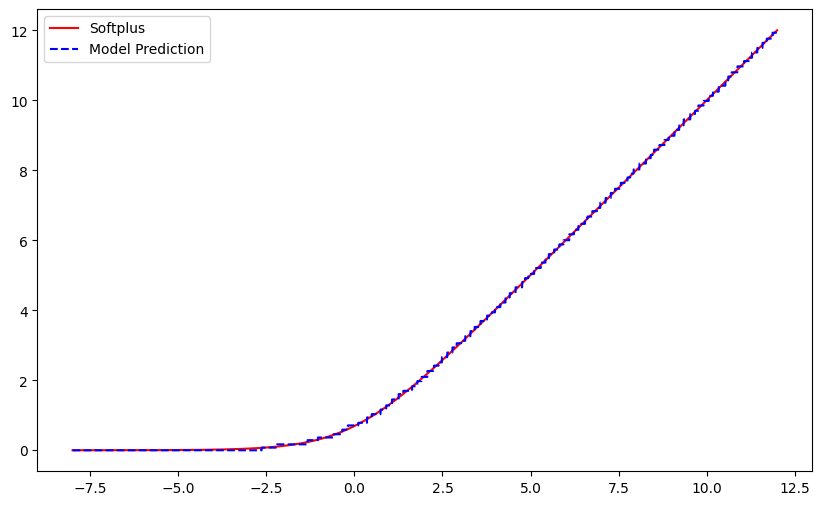

In [6]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.8653101325035095
Epoch 1001/20000, Loss: 0.02241935022175312
Epoch 2001/20000, Loss: 0.007604203652590513
Epoch 3001/20000, Loss: 0.003786548040807247
Epoch 4001/20000, Loss: 0.0022325129248201847
Epoch 5001/20000, Loss: 0.0018071444937959313
Epoch 6001/20000, Loss: 0.0016321911243721843
Epoch 7001/20000, Loss: 0.001219840720295906
Epoch 8001/20000, Loss: 0.0007862462662160397
Epoch 9001/20000, Loss: 0.0010330541990697384
Epoch 10001/20000, Loss: 0.0006791838677600026
Epoch 11001/20000, Loss: 0.0006243555690161884
Epoch 12001/20000, Loss: 0.0006534435087814927
Epoch 13001/20000, Loss: 0.0007493765442632139
Epoch 14001/20000, Loss: 0.0007190166506916285
Epoch 15001/20000, Loss: 0.001148704206570983
Epoch 16001/20000, Loss: 0.0009054508991539478
Epoch 17001/20000, Loss: 0.0008851774618960917
Epoch 18001/20000, Loss: 0.0008757433970458806
Epoch 19001/20000, Loss: 0.0007554016192443669
Loss values: [0.8653101325035095, 0.1750415414571762, 0.06643877178430557, 0.04459

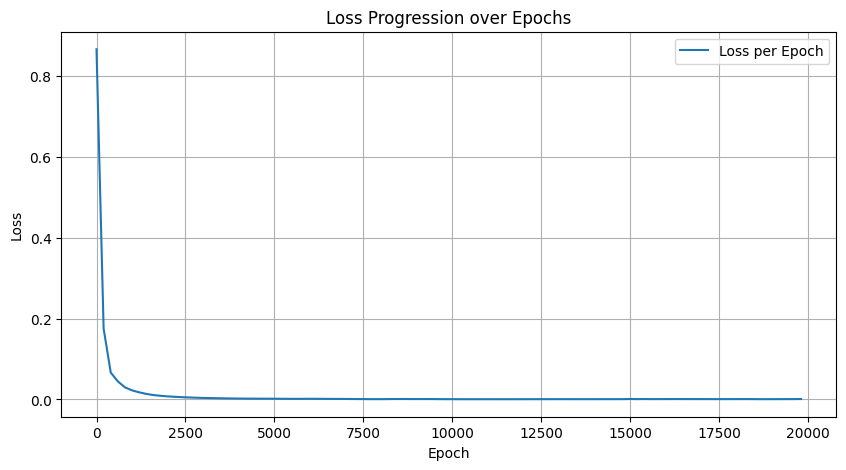

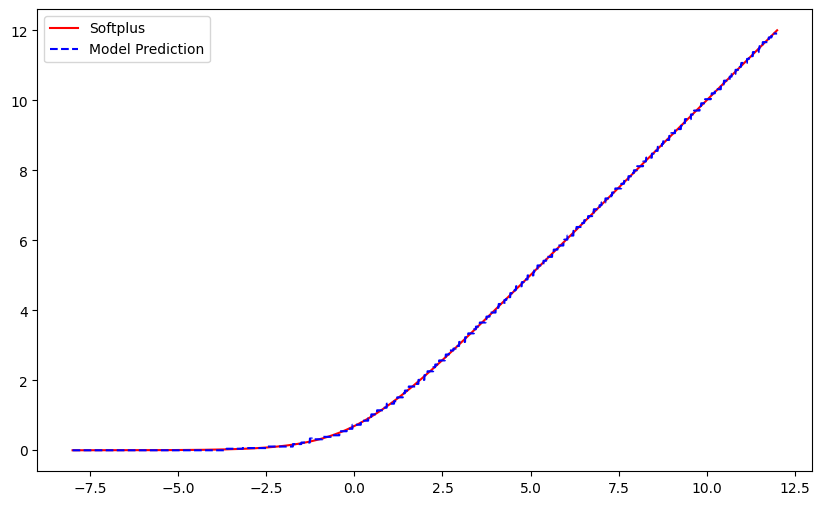

In [5]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()